In [0]:
#importing libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

**Loading and Processing data**

In [0]:
#reading csv data file
dataFrame = pd.read_csv("time_series_covid_19_confirmed.csv")

#selecting data till 27th May and dropping extra columns (i-e; Province/State, Lat, Long)
dataFrame = dataFrame.drop(dataFrame.columns[0], axis=1)
dataFrame = dataFrame.drop(dataFrame.columns[1:3], axis=1)
dataFrame = dataFrame.drop(dataFrame.columns[-3:], axis=1)

#grouping data of same country in one row 
new_Dataframe = dataFrame.groupby(['Country/Region']).sum().reset_index()

new_Dataframe

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,313,319,329,329,335,336,340,342,342,342,343,344,344,353,353,353,362,371,374,375,375,375,375,375,375,375,375,375,376,381,388,391,398,423,423,423,423,423,429,434
184,Western Sahara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,9,9,9,9
185,Yemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34,34,51,56,65,70,85,106,122,128,130,167,184,197,209,212,222,233,249,256
186,Zambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,57,61,65,70,74,76,84,84,88,88,95,97,106,109,119,124,137,138,146,153,167,252,267,267,441,446,654,654,679,753,761,772,832,866,920,920,920,920,920,1057


**Finding new cases per day from cumulative cases**

In [0]:
#another dataframe which contains no of new cases of each day
dataFrame_per_day_cases = new_Dataframe.copy()

#creating list of dates
dates_list = list(new_Dataframe)
dates_list.remove('Country/Region')

#no of countires(rows)
rows = len(new_Dataframe)

#no of dates(columns)
columns = len(dates_list)

for i in range(rows):
  for j in range(2, columns+1):
    per_day_cases = new_Dataframe.iat[i,j] - new_Dataframe.iat[i,j-1]
    dataFrame_per_day_cases.iat[i,j] = per_day_cases

dataFrame_per_day_cases

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,27,63,30,66,84,103,72,112,68,172,125,111,232,164,134,235,190,330,168,171,215,255,369,285,276,263,413,414,349,262,408,581,492,531,540,782,584,591,658,625
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9,14,22,25,25,29,15,34,14,10,14,16,7,9,7,6,8,17,12,10,8,6,12,4,4,4,18,18,17,13,2,1,15,5,12,8,9,6,25,21
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,116,95,89,93,99,97,120,129,126,135,132,199,158,148,141,179,174,190,159,185,187,189,165,168,176,186,189,187,192,198,182,176,165,186,190,195,193,197,194,160
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,9,4,0,6,0,8,7,0,5,0,0,2,0,2,1,2,1,0,1,0,2,1,0,3,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,1,0,0,0,1,1,0,0,0,3,5,0,0,1,0,0,7,0,2,0,0,0,3,0,0,0,2,2,0,6,2,1,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,6,10,0,6,1,4,2,0,0,1,1,0,9,0,0,9,9,3,1,0,0,0,0,0,0,0,0,1,5,7,3,7,25,0,0,0,0,6,5
184,Western Sahara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
185,Yemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,5,0,1,3,0,2,10,3,0,9,0,17,5,9,5,15,21,16,6,2,37,17,13,12,3,10,11,16,7
186,Zambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,4,4,5,4,2,8,0,4,0,7,2,9,3,10,5,13,1,8,7,14,85,15,0,174,5,208,0,25,74,8,11,60,34,54,0,0,0,0,137


**Finding correlations of other countries with Pakistan**

In [0]:
#removing index column for easing transpose 
new_Dataframe = new_Dataframe.groupby('Country/Region').sum()

#taking transpose of dataframe so that we can find correlations between countries 
transposed_dataframe = new_Dataframe.T

#creating list of countres
countries_list = list(transposed_dataframe)
countries_list.remove('Pakistan')

#finding correlations of other countries with Pakistan
correlations = []

for country in countries_list:
  correlation = transposed_dataframe['Pakistan'].corr(transposed_dataframe[country])
  correlations.append(correlation)

#create dataframe of countries and correlations 
correlations_dataframe = pd.DataFrame(list(zip(countries_list, correlations)), columns=['Country/Region','correlations_with_Pakistan'])

#sorting dataframe in decending order to find countries with maximum correlations 
correlations_dataframe = correlations_dataframe.sort_values('correlations_with_Pakistan', ascending=False)

#pick top5 countries (maximum correlated countries)
top5_countries = np.array(correlations_dataframe.iloc[:5,0])

correlations_dataframe.head()

,Country/Region,correlations_with_Pakistan
146,Saudi Arabia,0.998967
137,Qatar,0.998740
37,Colombia,0.998703
133,Peru,0.998608
53,Egypt,0.998586


**Gathering data of 5 most correlated countries and Pakistan for plotting**

In [0]:
#removing index column
dataFrame_per_day_cases = dataFrame_per_day_cases.groupby('Country/Region').sum()

#array containing maximum correlated countries
correlated_countries = []
correlated_countries[0:5] = top5_countries[0:5]
correlated_countries.insert(0,"Pakistan")

#cases data of maximum correlated countries for plotting graphs
countries_cases_data = []

for i in range(len(correlated_countries)):
  data = (dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == correlated_countries[i]]).to_numpy()
  countries_cases_data.append(data[0])

**plotting line graphs of 5 most correlated countries to see the trend of infection**

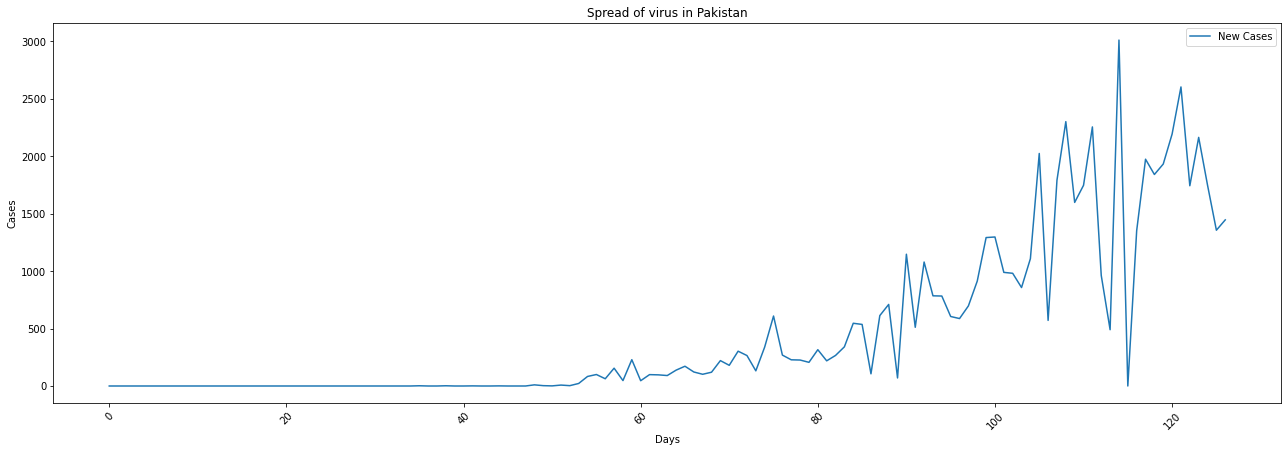

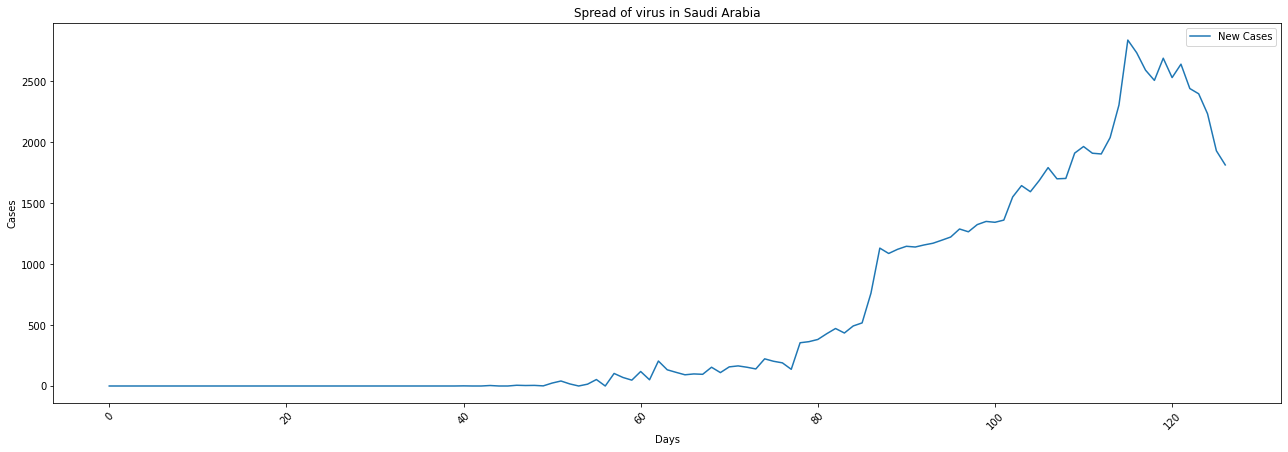

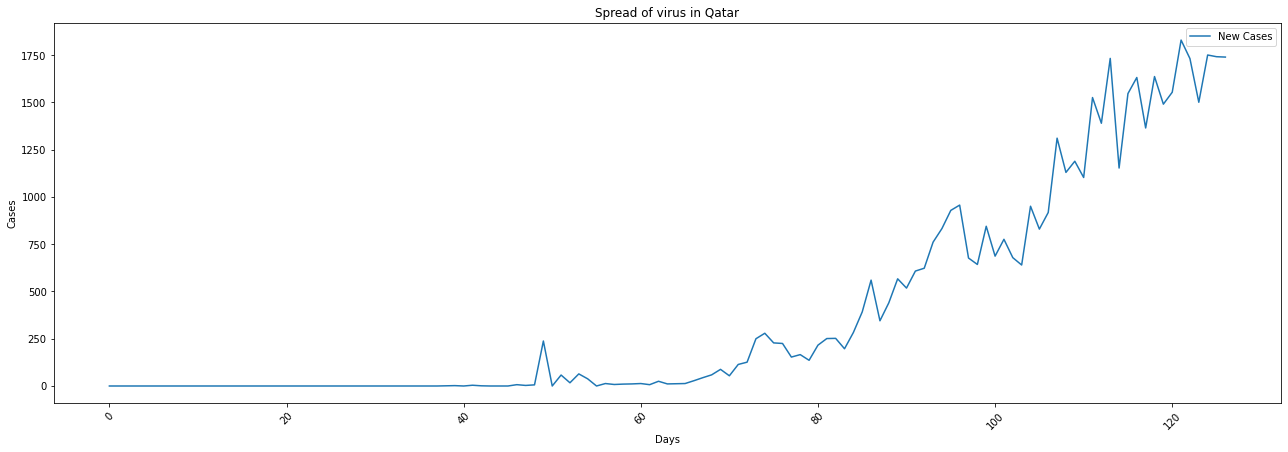

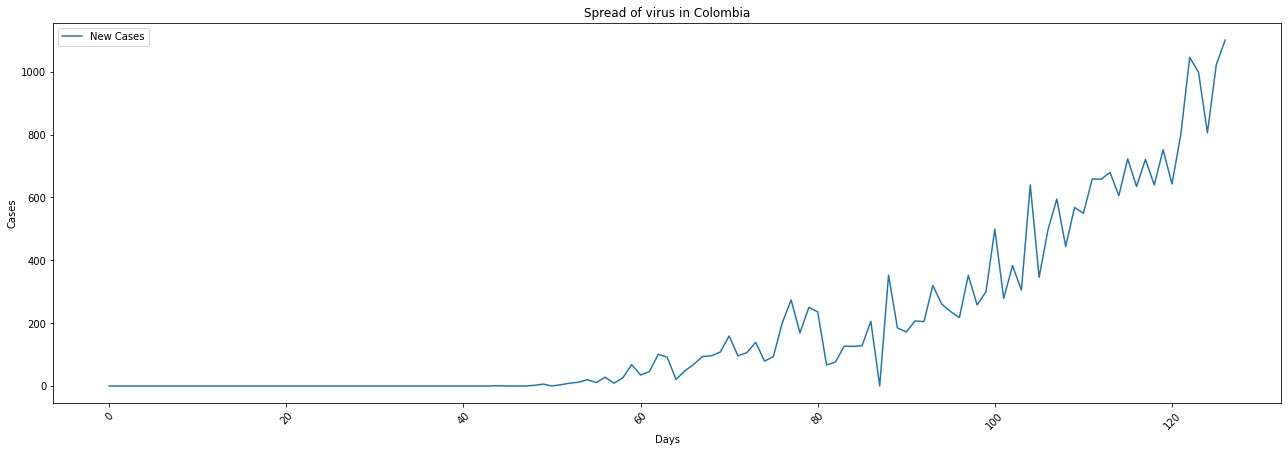

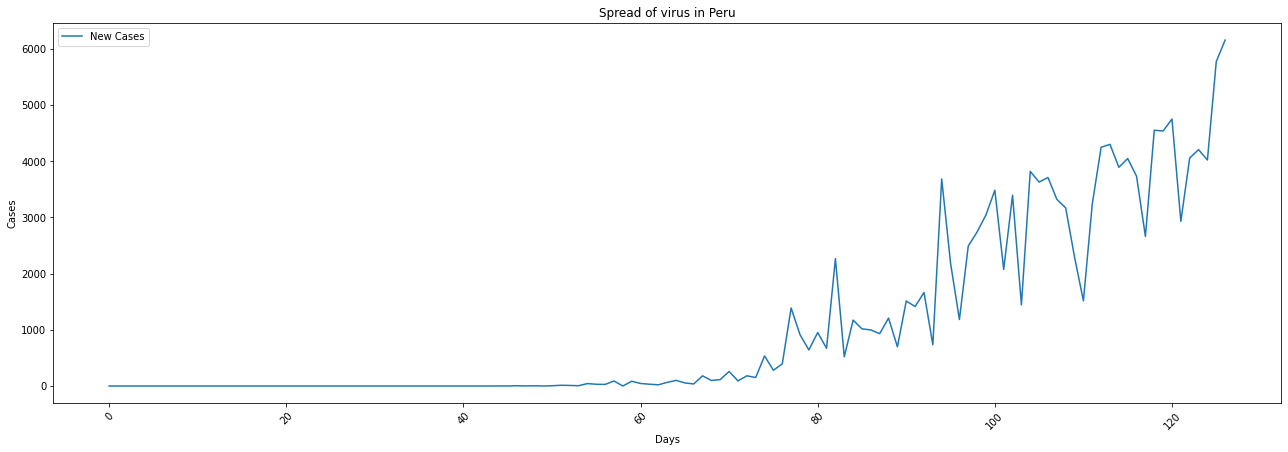

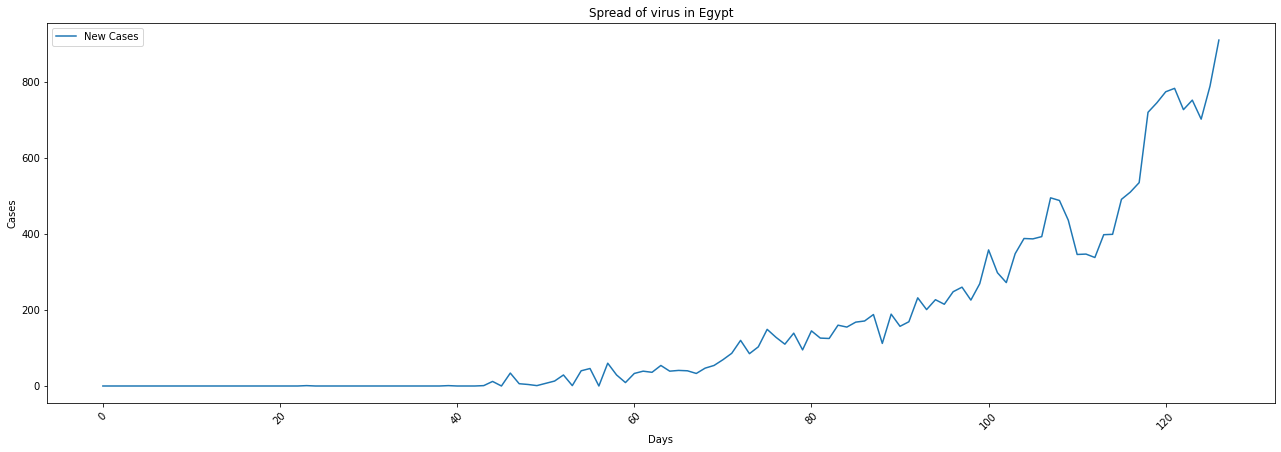

In [0]:
for i in range (len(correlated_countries)):
  plt.subplots(figsize=(22,7))
  
  # plotting line
  plt.plot(countries_cases_data[i], label = "New Cases")

  # Set X-axis, y-axis label and Title of the plot.
  plt.xticks(rotation=45)
  plt.xlabel('Days')
  plt.ylabel('Cases')
  plt.title('Spread of virus in '+ correlated_countries[i])
  plt.legend()
  plt.show()

**LSTM Model**

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()

        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

**Function for preprocessing data**

In [0]:
def data_preprocessing(data, window=10):

  #from initial 92 days, first 74 day's data(upto 9th May) is for training
  train_data = data[:-18]

  #and last 18 day's data (from 10th May onwards) is for testing
  test_data = data[74:]

  #normalizing training data in range (-1, 1) 
  scaler = MinMaxScaler(feature_range=(-1, 1))
  normalized_data = scaler.fit_transform(train_data .reshape(-1, 1))

  #converting normalized data into torch format
  normalized_data = torch.FloatTensor(normalized_data).view(-1)

  #creating chunks of (window_sequence,label) of  normalized data for training model 
  chunks = []
  for x in range(len(normalized_data)-window):
    sequence = normalized_data[x:x+window]
    label = normalized_data[x+window:x+window+1]
    chunks.append((sequence ,label))

  return scaler, normalized_data, chunks

**Function for training model**

In [0]:
def train_model(model, optimizer, criterion, chunks_data, epochs=100):

  for i in range(epochs):
    for sequence, labels in chunks_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

        training_predictions = model(sequence)
        loss_train = criterion(training_predictions, labels)
        loss_train.backward()
        optimizer.step()

    print('epoch: '+ str(i+1) + ' loss:' + str(round(loss_train.item(),6)))
  
  return model

**Function for testing model**

In [0]:
def test_model(model, data_normalized, scaler, prediction_days=30, window=10):
  
  #last window sequence from normalized data as input sequence
  test_sequence = data_normalized[-window:].tolist()
  model.eval()

  for day in range(prediction_days):
    sequence = torch.FloatTensor(test_sequence[-window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_sequence.append(model(sequence).item())
  
  #denormalizing predicted data
  test_predictions = scaler.inverse_transform(np.array(test_sequence[window:] ).reshape(-1, 1))

  return test_predictions

**Function for plotting actual & predicted line graphs**

In [0]:
def plot_line_graph(actual_data, predicted_data, given_country):
  plt.subplots(figsize=(22,7))
  #plt.autoscale(axis='x', tight=True)
  
  start1 = 1
  end1 = len(actual_data)+1
  start2 = len(actual_data)-17
  end2 = start2 + len(predicted_data)

  x1_labels = [i for i in range(start1,end1)]
  x2_labels = [i for i in range(start2, end2)]

  #plotting lines
  plt.plot(x1_labels, actual_data, label = "Actual Cases")
  plt.plot(x2_labels, predicted_data, label = "Predicted Cases")

  #set X-axis, y-axis label and Title of the plot.
  plt.xticks(rotation=45)
  plt.xlabel('Days')
  plt.ylabel('Cases')
  plt.title('Prediction of spread from '+ given_country +"'s data")
  plt.legend()
  plt.show()

**Function for finding RMSE(Root mean squared error)**

In [0]:
def rmse(actual_data, predicted_data):
  mse = mean_squared_error(actual_data[-18:], predicted_data[:18])
  rmse = np.sqrt(mse)
  print('RMSE: ',rmse)

**Training and predicting from 1st most correlated country's data**

In [0]:
#defining the model
country1_model = LSTM(1,100,1)

#defining the loss function
country1_criterion = nn.MSELoss()

#defining the optimizer
country1_optimizer = torch.optim.Adam(country1_model.parameters(), lr=0.001)

#Pakistan's data
pakistan_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == "Pakistan"].to_numpy()[0]

country1 = top5_countries[0]
country1_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == top5_countries[0]].to_numpy()[0]

#preprocess data
country1_scaler, country1_normalized_data, country1_data_chunks = data_preprocessing(country1_data, 21)

#train model
country1_model = train_model(country1_model, country1_optimizer, country1_criterion, country1_data_chunks, 100)

#predict model
country1_predictions = test_model(country1_model, country1_normalized_data, country1_scaler, 49, 21)

epoch: 1 loss:0.588063
epoch: 2 loss:0.001571
epoch: 3 loss:0.030128
epoch: 4 loss:0.054858
epoch: 5 loss:0.061877
epoch: 6 loss:0.028807
epoch: 7 loss:0.00707
epoch: 8 loss:0.010947
epoch: 9 loss:0.00889
epoch: 10 loss:0.007918
epoch: 11 loss:0.007075
epoch: 12 loss:0.006332
epoch: 13 loss:0.005672
epoch: 14 loss:0.005088
epoch: 15 loss:0.004577
epoch: 16 loss:0.004134
epoch: 17 loss:0.003755
epoch: 18 loss:0.003433
epoch: 19 loss:0.003164
epoch: 20 loss:0.00294
epoch: 21 loss:0.002758
epoch: 22 loss:0.002611
epoch: 23 loss:0.002496
epoch: 24 loss:0.002409
epoch: 25 loss:0.002347
epoch: 26 loss:0.002308
epoch: 27 loss:0.00229
epoch: 28 loss:0.002293
epoch: 29 loss:0.002316
epoch: 30 loss:0.00236
epoch: 31 loss:0.002423
epoch: 32 loss:0.002505
epoch: 33 loss:0.002601
epoch: 34 loss:0.002704
epoch: 35 loss:0.002801
epoch: 36 loss:0.002875
epoch: 37 loss:0.002909
epoch: 38 loss:0.002891
epoch: 39 loss:0.002821
epoch: 40 loss:0.002709
epoch: 41 loss:0.002575
epoch: 42 loss:0.002439
epoch:

**Training and predicting from 2nd most correlated country's data**

In [0]:
#defining the model
country2_model = LSTM(1,100,1)

#defining the loss function
country2_criterion = nn.MSELoss()

#defining the optimizer
country2_optimizer = torch.optim.Adam(country2_model.parameters(), lr=0.001)

country2 = top5_countries[1]
country2_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == top5_countries[1]].to_numpy()[0]

#preprocess data
country2_scaler, country2_normalized_data, country2_data_chunks = data_preprocessing(country2_data, 21)

#train model
country2_model = train_model(country2_model, country2_optimizer, country2_criterion, country2_data_chunks, 120)

#predict model
country2_predictions = test_model(country2_model, country2_normalized_data, country2_scaler, 49, 21)

epoch: 1 loss:0.525715
epoch: 2 loss:0.458239
epoch: 3 loss:0.30496
epoch: 4 loss:0.090525
epoch: 5 loss:0.288231
epoch: 6 loss:0.244097
epoch: 7 loss:0.088156
epoch: 8 loss:0.039108
epoch: 9 loss:0.030601
epoch: 10 loss:0.023523
epoch: 11 loss:0.019916
epoch: 12 loss:0.015119
epoch: 13 loss:0.012703
epoch: 14 loss:0.009912
epoch: 15 loss:0.008055
epoch: 16 loss:0.006362
epoch: 17 loss:0.005054
epoch: 18 loss:0.003968
epoch: 19 loss:0.003092
epoch: 20 loss:0.002378
epoch: 21 loss:0.001795
epoch: 22 loss:0.001318
epoch: 23 loss:0.000926
epoch: 24 loss:0.000605
epoch: 25 loss:0.000346
epoch: 26 loss:0.000148
epoch: 27 loss:2.3e-05
epoch: 28 loss:2e-05
epoch: 29 loss:0.000372
epoch: 30 loss:0.003036
epoch: 31 loss:0.029192
epoch: 32 loss:0.043825
epoch: 33 loss:0.013498
epoch: 34 loss:0.036296
epoch: 35 loss:0.002502
epoch: 36 loss:0.006943
epoch: 37 loss:0.002739
epoch: 38 loss:0.004939
epoch: 39 loss:0.001438
epoch: 40 loss:0.025114
epoch: 41 loss:0.022976
epoch: 42 loss:0.036826
epoch:

**Training and predicting from 3rd most correlated country's data**

In [0]:
#defining the model
country3_model = LSTM(1,100,1)

#defining the loss function
country3_criterion = nn.MSELoss()

#defining the optimizer
country3_optimizer = torch.optim.Adam(country3_model.parameters(), lr=0.001)

country3 = top5_countries[2]
country3_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == top5_countries[2]].to_numpy()[0]

#preprocess data
country3_scaler, country3_normalized_data, country3_data_chunks = data_preprocessing(country3_data, 21)

#train model
country3_model = train_model(country3_model, country3_optimizer, country3_criterion, country3_data_chunks, 120)

#predict model
country3_predictions = test_model(country3_model, country3_normalized_data, country3_scaler, 49, 21)

epoch: 1 loss:0.280525
epoch: 2 loss:0.226315
epoch: 3 loss:0.129951
epoch: 4 loss:0.010309
epoch: 5 loss:0.236473
epoch: 6 loss:0.064386
epoch: 7 loss:8.2e-05
epoch: 8 loss:0.13971
epoch: 9 loss:0.218447
epoch: 10 loss:0.101668
epoch: 11 loss:0.191828
epoch: 12 loss:0.09209
epoch: 13 loss:0.162329
epoch: 14 loss:0.090576
epoch: 15 loss:0.1399
epoch: 16 loss:0.085902
epoch: 17 loss:0.123136
epoch: 18 loss:0.075296
epoch: 19 loss:0.10896
epoch: 20 loss:0.055317
epoch: 21 loss:0.097291
epoch: 22 loss:0.021882
epoch: 23 loss:0.125711
epoch: 24 loss:0.00089
epoch: 25 loss:0.134036
epoch: 26 loss:0.005605
epoch: 27 loss:0.09207
epoch: 28 loss:0.012111
epoch: 29 loss:0.066356
epoch: 30 loss:0.003863
epoch: 31 loss:0.076509
epoch: 32 loss:0.00161
epoch: 33 loss:0.106523
epoch: 34 loss:9.6e-05
epoch: 35 loss:0.076093
epoch: 36 loss:0.000989
epoch: 37 loss:0.053224
epoch: 38 loss:0.000908
epoch: 39 loss:0.053446
epoch: 40 loss:0.000934
epoch: 41 loss:0.078846
epoch: 42 loss:0.002549
epoch: 43 l

**Training and predicting from 4th most correlated country's data**

In [292]:
#defining the model
country4_model = LSTM(1,100,1)

#defining the loss function
country4_criterion = nn.MSELoss()

#defining the optimizer
country4_optimizer = torch.optim.Adam(country4_model.parameters(), lr=0.001)

country4 = top5_countries[3]
country4_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == top5_countries[3]].to_numpy()[0]

#preprocess data
country4_scaler, country4_normalized_data, country4_data_chunks = data_preprocessing(country4_data, 21)

#train model
country4_model = train_model(country4_model, country4_optimizer, country4_criterion, country4_data_chunks, 100)

#predict model
country4_predictions = test_model(country4_model, country4_normalized_data, country4_scaler, 49, 21)

epoch: 1 loss:0.387798
epoch: 2 loss:0.250739
epoch: 3 loss:0.007297
epoch: 4 loss:0.042185
epoch: 5 loss:0.075854
epoch: 6 loss:0.034185
epoch: 7 loss:0.162475
epoch: 8 loss:0.01871
epoch: 9 loss:0.094687
epoch: 10 loss:0.042219
epoch: 11 loss:0.063485
epoch: 12 loss:0.039832
epoch: 13 loss:0.044565
epoch: 14 loss:0.030516
epoch: 15 loss:0.027969
epoch: 16 loss:0.016087
epoch: 17 loss:0.011338
epoch: 18 loss:0.006244
epoch: 19 loss:0.004609
epoch: 20 loss:0.003237
epoch: 21 loss:0.002394
epoch: 22 loss:3.4e-05
epoch: 23 loss:0.004705
epoch: 24 loss:0.006972
epoch: 25 loss:0.003524
epoch: 26 loss:0.003372
epoch: 27 loss:0.000716
epoch: 28 loss:0.00755
epoch: 29 loss:0.007665
epoch: 30 loss:0.008809
epoch: 31 loss:0.015328
epoch: 32 loss:0.03856
epoch: 33 loss:0.119665
epoch: 34 loss:0.036059
epoch: 35 loss:0.187101
epoch: 36 loss:0.146997
epoch: 37 loss:0.014036
epoch: 38 loss:0.003145
epoch: 39 loss:0.0
epoch: 40 loss:0.038218
epoch: 41 loss:0.032116
epoch: 42 loss:0.12262
epoch: 43 l

**Training and predicting from 5th most correlated country's data**

In [589]:
#defining the model
country5_model = LSTM(1,100,1)

#defining the loss function
country5_criterion = nn.MSELoss()

#defining the optimizer
country5_optimizer = torch.optim.Adam(country5_model.parameters(), lr=0.001)

country5 = top5_countries[4]
country5_data = dataFrame_per_day_cases.loc[dataFrame_per_day_cases.index == top5_countries[4]].to_numpy()[0]

#preprocess data
country5_scaler, country5_normalized_data, country5_data_chunks = data_preprocessing(country5_data, 21)

#train model
country5_model = train_model(country5_model, country5_optimizer, country5_criterion, country5_data_chunks, 100)

#predict model
country5_predictions = test_model(country5_model, country5_normalized_data, country5_scaler, 49, 21)

epoch: 1 loss:0.99868
epoch: 2 loss:0.728301
epoch: 3 loss:0.046289
epoch: 4 loss:0.000656
epoch: 5 loss:0.026269
epoch: 6 loss:0.000463
epoch: 7 loss:0.071275
epoch: 8 loss:0.00381
epoch: 9 loss:0.429276
epoch: 10 loss:0.035785
epoch: 11 loss:0.063382
epoch: 12 loss:0.110667
epoch: 13 loss:0.03592
epoch: 14 loss:0.003775
epoch: 15 loss:0.028449
epoch: 16 loss:0.017403
epoch: 17 loss:0.021413
epoch: 18 loss:0.012516
epoch: 19 loss:0.017321
epoch: 20 loss:0.010357
epoch: 21 loss:0.015552
epoch: 22 loss:0.01086
epoch: 23 loss:0.015013
epoch: 24 loss:0.013076
epoch: 25 loss:0.014972
epoch: 26 loss:0.016042
epoch: 27 loss:0.014983
epoch: 28 loss:0.018406
epoch: 29 loss:0.014873
epoch: 30 loss:0.019437
epoch: 31 loss:0.014658
epoch: 32 loss:0.019503
epoch: 33 loss:0.014398
epoch: 34 loss:0.019213
epoch: 35 loss:0.014088
epoch: 36 loss:0.018836
epoch: 37 loss:0.013544
epoch: 38 loss:0.018311
epoch: 39 loss:0.011286
epoch: 40 loss:0.017351
epoch: 41 loss:0.014149
epoch: 42 loss:0.026089
epoch

**plotting graphs of predictions from 1st most correlarted country's data**

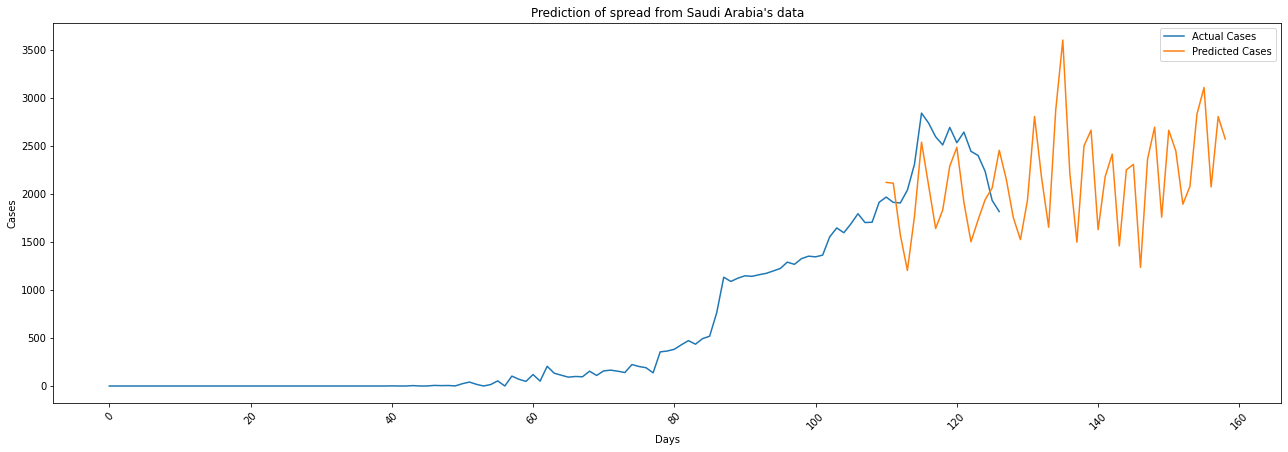

RMSE of predicted with it's actual data
RMSE:  580.5797434217287


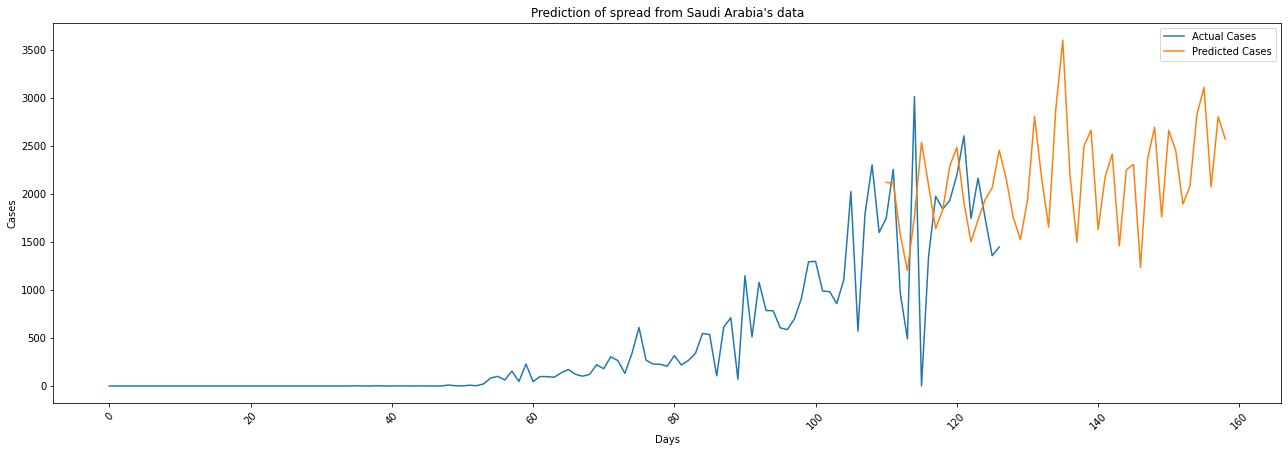

RMSE of predicted with Pakistan's data
RMSE:  777.5589177833187


In [0]:
plot_line_graph(country1_data, country1_predictions, country1)
print("RMSE of predicted with it's actual data")
rmse(country1_data, country1_predictions)

plot_line_graph(pakistan_data, country1_predictions, country1)
print("RMSE of predicted with Pakistan's data")
rmse(pakistan_data, country1_predictions)

**plotting graphs of predictions from 2nd most correlarted country's data**

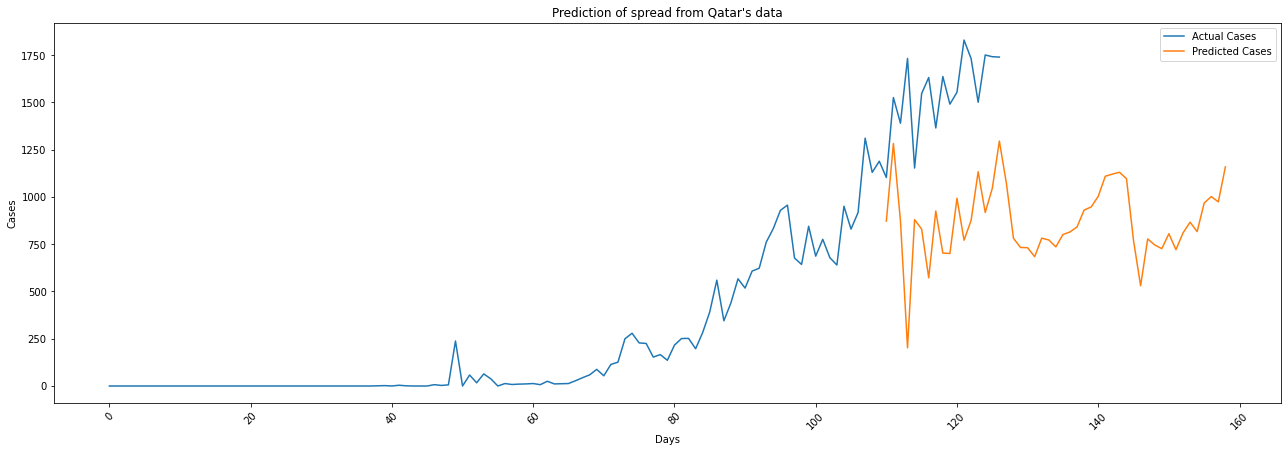

RMSE of predicted with it's actual data
RMSE:  714.0563390261977


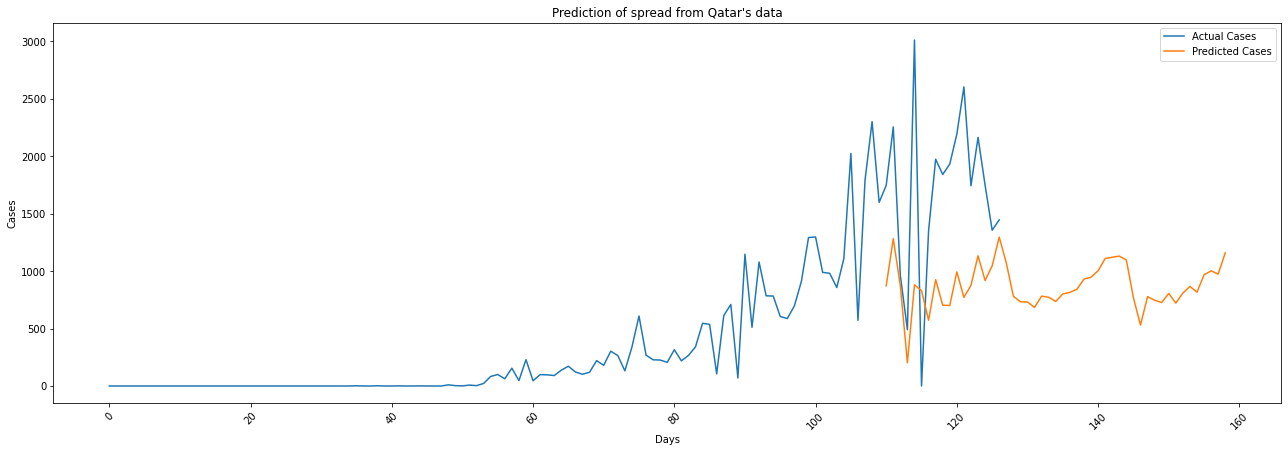

RMSE of predicted with Pakistan's data
RMSE:  1054.355193591891


In [0]:
plot_line_graph(country2_data, country2_predictions, country2)
print("RMSE of predicted with it's actual data")
rmse(country2_data, country2_predictions)

plot_line_graph(pakistan_data, country2_predictions, country2)
print("RMSE of predicted with Pakistan's data")
rmse(pakistan_data, country2_predictions)

**plotting graphs of predictions from 3rd most correlarted country's data**

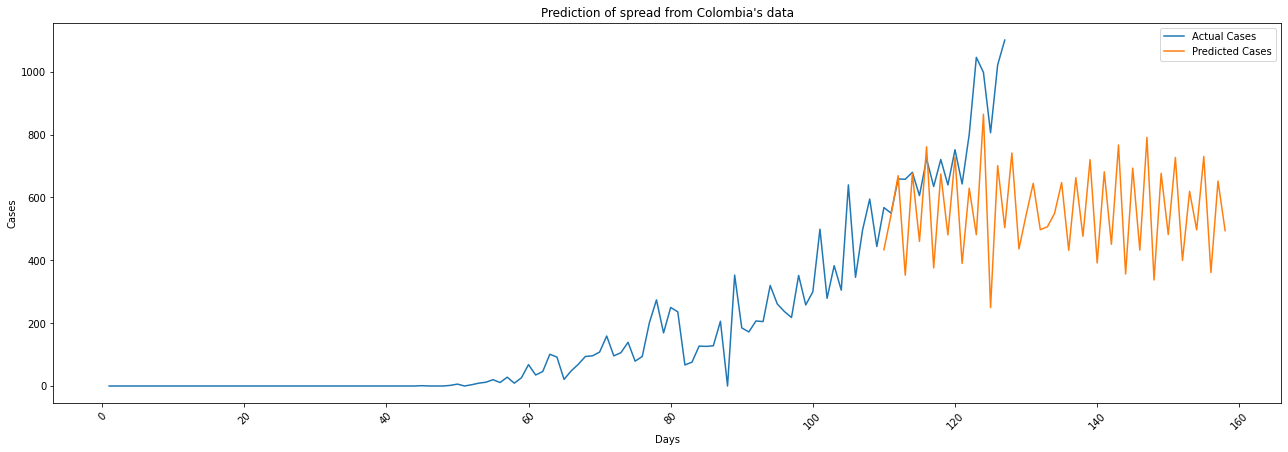

RMSE of predicted with it's actual data
RMSE:  281.68008612912854


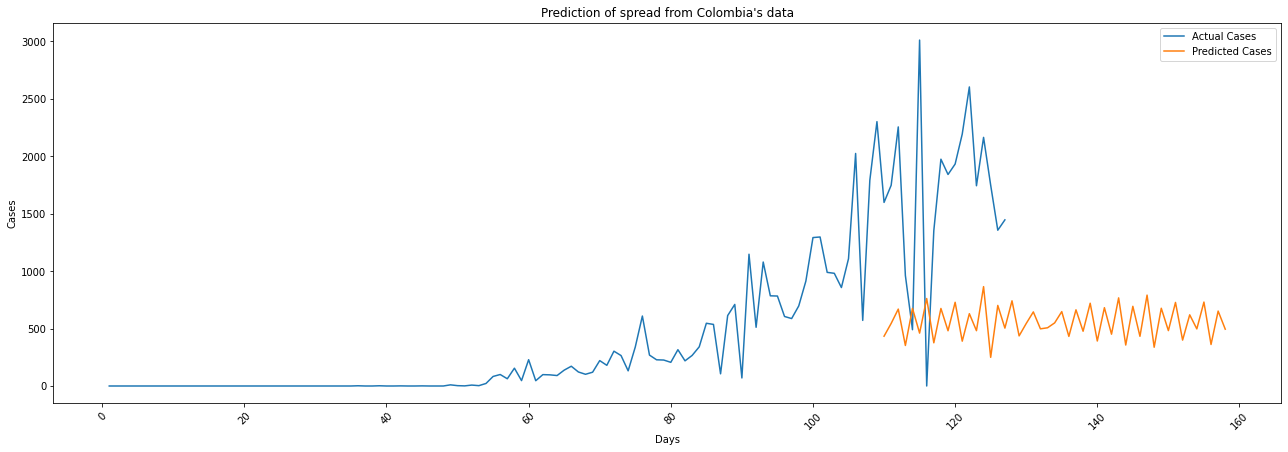

RMSE of predicted with Pakistan's data
RMSE:  1348.5035889756462


In [0]:
plot_line_graph(country3_data, country3_predictions, country3)
print("RMSE of predicted with it's actual data")
rmse(country3_data, country3_predictions)

plot_line_graph(pakistan_data, country3_predictions, country3)
print("RMSE of predicted with Pakistan's data")
rmse(pakistan_data, country3_predictions)

**plotting graphs of predictions from 4th most correlarted country's data**

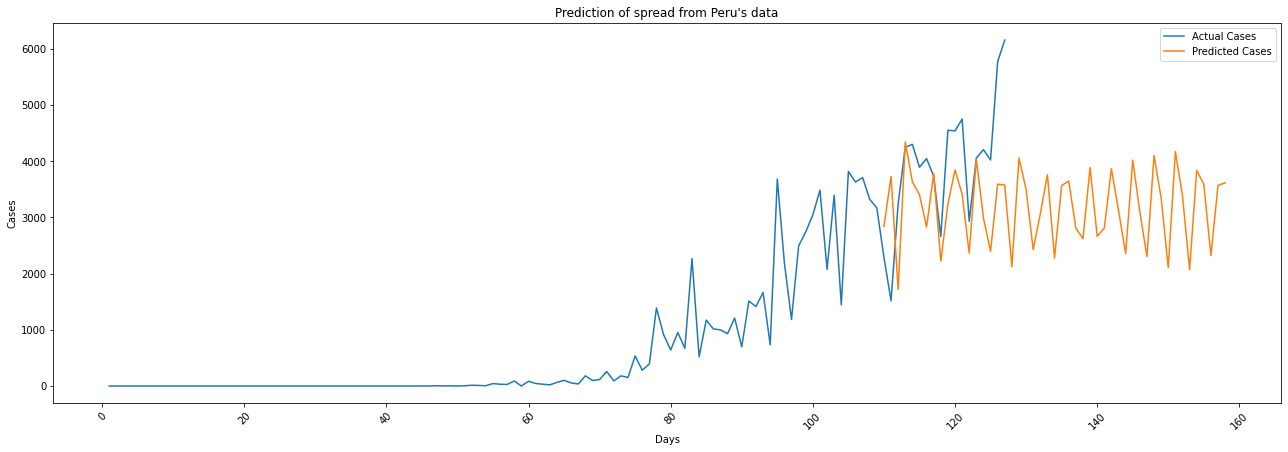

RMSE of predicted with it's actual data
RMSE:  1284.701403687876


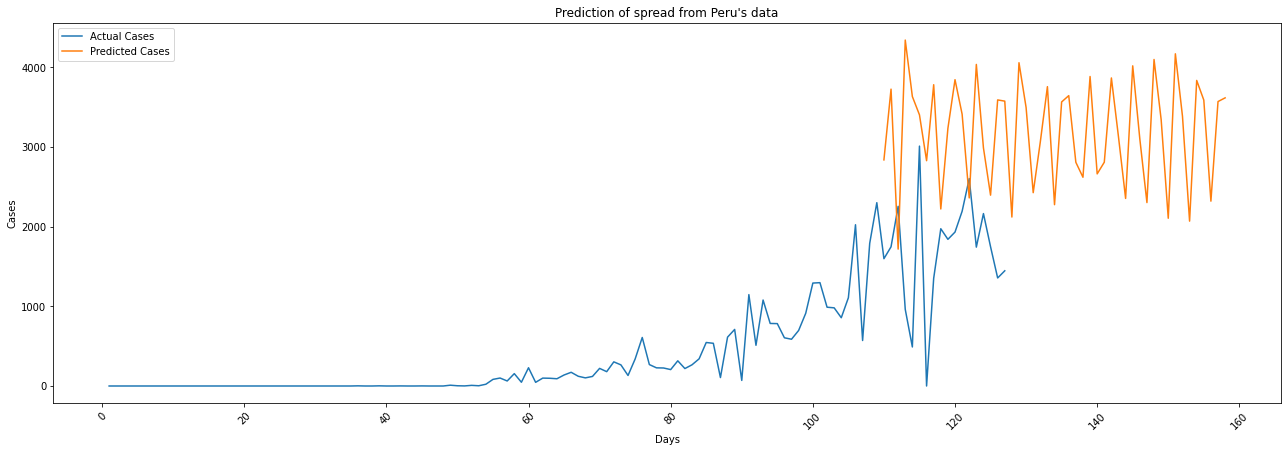

RMSE of predicted with Pakistan's data
RMSE:  1888.4687596394679


In [413]:
plot_line_graph(country4_data, country4_predictions, country4)
print("RMSE of predicted with it's actual data")
rmse(country4_data, country4_predictions)

plot_line_graph(pakistan_data, country4_predictions, country4)
print("RMSE of predicted with Pakistan's data")
rmse(pakistan_data, country4_predictions)

**plotting graphs of predictions from 5th most correlarted country's data**

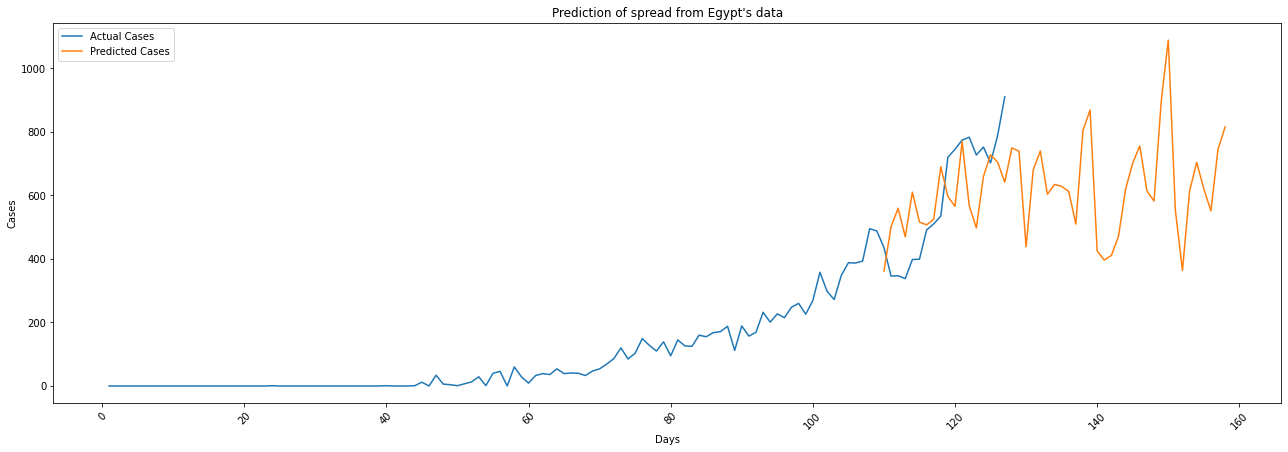

RMSE of predicted with it's actual data
RMSE:  150.9342164350418


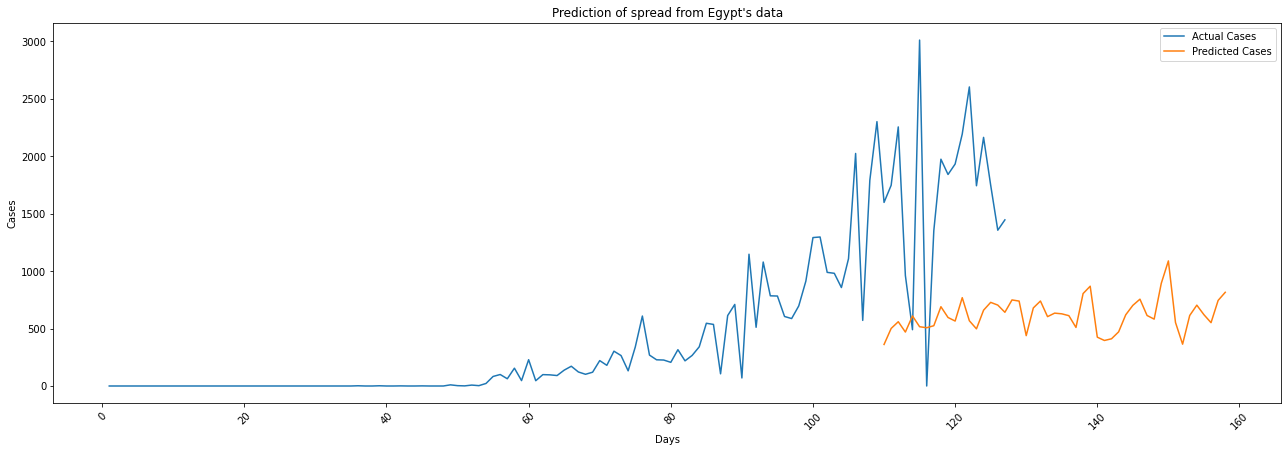

RMSE of predicted with Pakistan's data
RMSE:  1302.6186549545494


In [675]:
plot_line_graph(country5_data, country5_predictions, country5)
print("RMSE of predicted with it's actual data")
rmse(country5_data, country5_predictions)

plot_line_graph(pakistan_data, country5_predictions, country5)
print("RMSE of predicted with Pakistan's data")
rmse(pakistan_data, country5_predictions)

**Training and predicting from Pakistan's data**

In [855]:
#defining the model
model_for_pakistan = LSTM(1,100,1)

#defining the loss function
criterion_for_pakistan = nn.MSELoss()

#defining the optimizer
optimizer_for_pakistan = torch.optim.Adam(model_for_pakistan.parameters(), lr=0.001)

#preprocess data
pakistan_scaler, pakistan_normalized_data, pakistan_data_chunks = data_preprocessing(pakistan_data, 31)

#train model
model_for_pakistan = train_model(model_for_pakistan, optimizer_for_pakistan, criterion_for_pakistan, pakistan_data_chunks, 90)

#predict model
pakistan_predictions = test_model(model_for_pakistan, pakistan_normalized_data, pakistan_scaler, 49, 31)

epoch: 1 loss:1.301745
epoch: 2 loss:1.294423
epoch: 3 loss:1.254887
epoch: 4 loss:1.17449
epoch: 5 loss:1.07005
epoch: 6 loss:0.902779
epoch: 7 loss:0.557731
epoch: 8 loss:0.509148
epoch: 9 loss:0.278822
epoch: 10 loss:0.225382
epoch: 11 loss:0.207005
epoch: 12 loss:0.187862
epoch: 13 loss:0.236714
epoch: 14 loss:0.452155
epoch: 15 loss:0.131791
epoch: 16 loss:0.439835
epoch: 17 loss:0.092584
epoch: 18 loss:0.289878
epoch: 19 loss:0.085223
epoch: 20 loss:0.487185
epoch: 21 loss:0.094672
epoch: 22 loss:0.106328
epoch: 23 loss:0.067609
epoch: 24 loss:0.170009
epoch: 25 loss:0.07023
epoch: 26 loss:0.631739
epoch: 27 loss:0.20733
epoch: 28 loss:0.043744
epoch: 29 loss:0.367317
epoch: 30 loss:0.046324
epoch: 31 loss:0.220251
epoch: 32 loss:0.031816
epoch: 33 loss:0.518931
epoch: 34 loss:0.108185
epoch: 35 loss:0.040317
epoch: 36 loss:0.244413
epoch: 37 loss:0.023785
epoch: 38 loss:0.637898
epoch: 39 loss:0.218685
epoch: 40 loss:0.027059
epoch: 41 loss:0.333397
epoch: 42 loss:0.018389
epoch

**plotting graph of prediction from Pakistan's data**

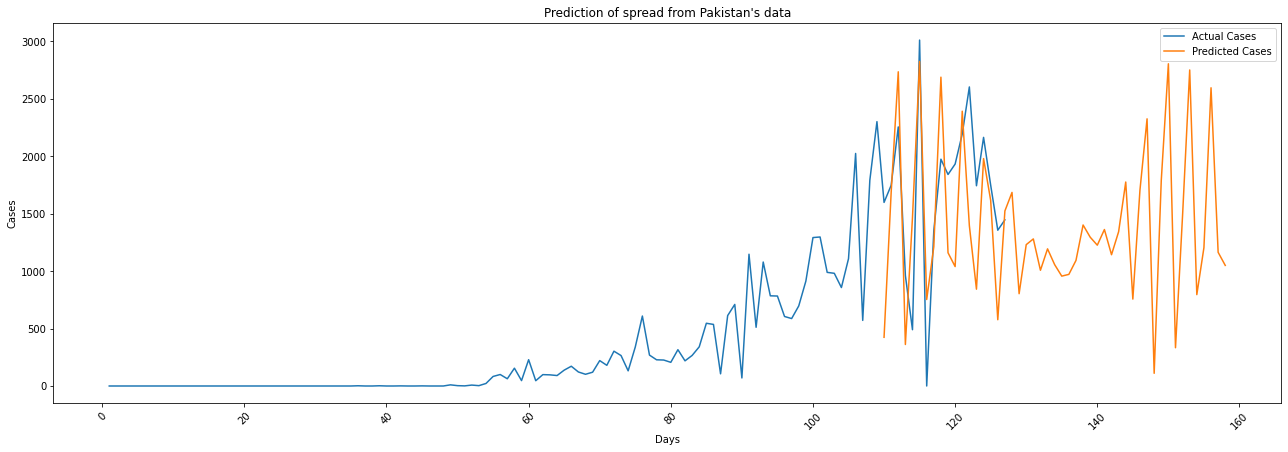

RMSE of predicted with it's actual(Pakistan's) data
RMSE:  678.7931617826732


In [974]:
plot_line_graph(pakistan_data, pakistan_predictions, "Pakistan")
print("RMSE of predicted with it's actual(Pakistan's) data")
rmse(pakistan_data, pakistan_predictions)

**Differences**: In many graphs the predicted values were less that the actual values because the model was trained on that data whose scale was less and the testing data was large scaled, that's why in some graphs there is difference in predicted and actual graphs scale.

**Similarities**: After training about 80+ epochs the actual and predicted graphs shape were similar but in that case the there was huge scale difference.

**Peculiarities**: A similar abnormal behaviour was seen in every predicted graph. After training model on about 200+ epochs the predicted graphs shape were approximately sine wave shape.

**How different countries predict different trends for Pakistan**


1.   **Saudi Arabia** predicts approximately similar trend but not well scaled for Pakistan.
2.   **Qatar** predicts some how similar trend of about 5 days for Pakistan.
3.   **Colombia** predicts similar trend of about 1 day for Pakistan.
4.   **Peru** predicts similar trend for Pakistan but with large scale than Pakistan's scale. 
5.   **Egypt** does not predict well for Pakistan.

From graphs we can see that **Saudi Arabia** is the best one in predicting trend for Pakistan from other countries. It predicts about 3500+ per day cases in June(for future). 

